In [1]:
import sqlite3
import pathlib
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Locating files
current_file_path = pathlib.Path().resolve()
base_folder = current_file_path.parents[0]
database_path = base_folder.joinpath('2. Data\\Database\\nrdp_fare_data.db')

In [7]:
# reading database table into a dataframe
db_conn = sqlite3.connect(database_path)
flow_fare_loc_df = pd.read_sql_query('SELECT * FROM flow_fare_location', db_conn)
db_conn.close()

In [12]:
flow_fare_loc_df['ORIGIN_COORDS'] = list(zip(flow_fare_loc_df.ORIGIN_LAT,flow_fare_loc_df.ORIGIN_LON))
flow_fare_loc_df['DESTINATION_COORDS'] = list(zip(flow_fare_loc_df.DESTINATION_LAT,flow_fare_loc_df.DESTINATION_LON))

In [19]:
network_df = flow_fare_loc_df[['ORIGIN_CODE','DESTINATION_CODE','FARE_POUNDS','ORIGIN_COORDS','DESTINATION_COORDS']].copy()
network_df

,ORIGIN_CODE,DESTINATION_CODE,FARE_POUNDS,ORIGIN_COORDS,DESTINATION_COORDS
0,5932,1360,57.8,"(50.907742, -1.413983)","(51.995339, -0.736368)"
1,5932,1373,56.7,"(50.907742, -1.413983)","(51.916046, -0.676874)"
2,5932,1378,57.8,"(50.907742, -1.413983)","(52.034357, -0.77341)"
3,5932,1390,51.3,"(50.907742, -1.413983)","(51.763638, -0.562498)"
4,5932,1391,47.7,"(50.907742, -1.413983)","(51.742062, -0.490762)"
...,...,...,...,...,...
122071,3121,3052,25.5,"(51.8042, -1.2745)","(51.578495, -0.497633)"
122072,3121,3057,27.7,"(51.8042, -1.2745)","(51.556742, -0.398812)"
122073,3121,3059,27.7,"(51.8042, -1.2745)","(51.569708, -0.437812)"
122074,3121,3060,25.7,"(51.8042, -1.2745)","(51.580544, -0.517774)"


In [22]:
stations = {}
routes = []
for i in range(len(network_df)):
    stations[network_df['ORIGIN_CODE'][i]]=network_df['ORIGIN_COORDS'][i]
    stations[network_df['DESTINATION_CODE'][i]]=network_df['DESTINATION_COORDS'][i]
    routes.append((network_df['ORIGIN_CODE'][i],network_df['DESTINATION_CODE'][i],network_df['FARE_POUNDS'][i]))

In [39]:
# Forming graph
G = nx.Graph()
for i in range(len(routes)):
    G.add_edge(stations[routes[i][0]],stations[routes[i][1]],weight=routes[i][2])
pos = {value:value for key, value in stations.items()} # Creates nodes in graph

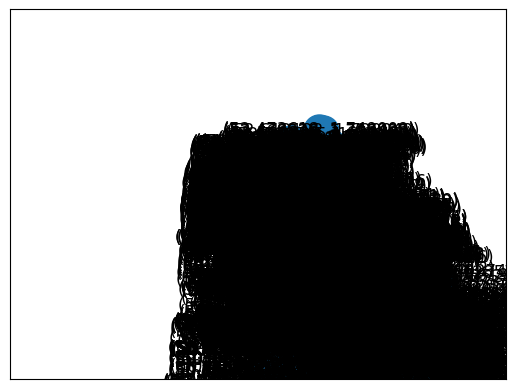

In [40]:
# Displaying graph
fig, ax = plt.subplots()
nx.draw(G, pos=pos, node_color='k', ax=ax)
nx.draw(G, pos=pos, node_size=500, ax=ax) # draw nodes and edges
nx.draw_networkx_labels(G, pos=pos) #draw node labels
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, ax=ax)
plt.axis("on")
ax.set_xlim(40,60)
ax.set_ylim(-5,5)
plt.show()